# Resubmission, Jan 2022

In [3]:
%reload_ext autoreload
%autoreload 2

from cleaning_funcs import *
from viz_funcs import *

import os
import pandas as pd
import numpy as np

%matplotlib inline


/home/christiana/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/christiana/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Load Data

In [4]:
lab_df = pd.read_csv('data/preproc_lab_data_pub_20220218_nl.csv',
                     dtype={'anon_producer':str})
strain_info = pd.read_csv('data/strain_info_pub_20210915.csv')

In [3]:
lab_df.head()

,u_id,lab_id,strain_slug,anon_producer,region,product_category,strain_category,strain_popularity,chemotype,has_cannabs,chemotype_ratio,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,has_terps,total_terps,terp_var,top_terp_f,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene
0,0,lab0,NaN,1046,AK,FLOWER,None,NaN,THC-Dom,True,425.819531,20.103098,0.047210,1.097430,0.000000,0.0,0.255775,True,2.042793,0.020911,caryophyllene,0.251212,0.01,0.015323,0.010000,0.217018,0.560682,0.159195,0.032776,0.177072,0.029597,0.114252,0.010000,0.321310,0.075442
1,1,lab0,NaN,1046,AK,FLOWER,None,NaN,THC-Dom,True,207.384250,17.775078,0.085711,0.904467,0.046734,0.0,0.050000,True,1.802569,0.015647,tot_ocimene,0.374661,0.01,0.015079,0.022216,0.143383,0.315326,0.127196,0.010000,0.199761,0.010000,0.069859,0.012731,0.365565,0.060920
2,2,lab0,NaN,1046,AK,FLOWER,None,NaN,THC-Dom,True,230.122927,18.196924,0.079075,0.923358,0.056123,0.0,0.050000,True,1.657769,0.013292,terpinolene,0.334714,0.01,0.013090,0.026730,0.140367,0.306051,0.111072,0.022061,0.177568,0.010000,0.057884,0.011981,0.336826,0.049393
3,3,lab0,NaN,1046,AK,FLOWER,None,NaN,THC-Dom,True,321.904704,19.302718,0.059964,0.517679,0.034465,0.0,0.050000,True,1.247020,0.013983,caryophyllene,0.010000,0.01,0.010000,0.000000,0.167629,0.385306,0.134872,0.056048,0.368547,0.048849,0.035711,0.000000,0.000000,0.020058
4,4,lab0,NaN,1046,AK,FLOWER,None,NaN,THC-Dom,True,253.209507,18.224250,0.071973,0.966903,0.000000,0.0,0.231606,True,1.262112,0.006794,caryophyllene,0.158674,0.01,0.014013,0.010000,0.127600,0.317787,0.116072,0.029350,0.099418,0.010000,0.083642,0.010000,0.179980,0.056437


In [3]:
common_cannabs = ['tot_thc',
                'tot_cbd',
                'tot_cbg',
                'tot_cbc',
                'tot_cbn',
                'tot_thcv']

tot_cannab_cols = ['tot_thc',
'tot_cbd',
'tot_cbg',
'tot_cbc',
'tot_cbn',
# 'tot_cbdv',
# 'tot_cbt',
# 'tot_d8_thc',
'tot_thcv']

lab_df['total_cannabs'] = lab_df.loc[:, tot_cannab_cols].sum(axis=1)

In [4]:
common_terps = ['tot_ocimene', 'camphene', 'g_terpinene', 'tot_nerolidol_ct',
       'humulene', 'caryophyllene', 'limonene', 'linalool', 'myrcene',
       'bisabolol', 'b_pinene', 'a_terpinene', 'terpinolene', 'a_pinene']

In [5]:
terp_df = lab_df[lab_df['has_terps']].copy()
thc_bool = terp_df['chemotype']=='THC-Dom'


In [7]:
def unique_count(x):
    return x.dropna().unique().shape[0]


lab_df[['anon_producer','strain_slug']].agg({'anon_producer':unique_count, 'strain_slug':unique_count})

anon_producer    3319
strain_slug      3087
dtype: int64

In [12]:
lab_df.loc[lab_df['total_cannabs']<=1].shape

(64, 36)

## Figure 2

Our regression plots originally looked a little odd. This is likely due to outliers. Setting the seaborn regression to be robust to outliers was not sufficient, so we instead designated MAD outliers and left them out of the regressions.


In [6]:
def pearson_sig_string(s1,s2):
    _r,_p = scs.pearsonr(s1.fillna(0),s2.fillna(0))
    if _p < 0.001:
        return 'r={0:.2f}***'.format(_r)
    elif _p < 0.01:
        return 'r={0:.2f}**'.format(_r)
    elif _p < 0.05:
        return 'r={0:.2f}*'.format(_r)
    else:
        return 'r={0:.2f}'.format(_r)
    
def spearman_sig_string(s1,s2):
    _r,_p = scs.spearmanr(s1.fillna(0),s2.fillna(0))
    if _p < 0.0001/9:
        return 'r={0:.2f}***'.format(_r)
    elif _p < 0.001/9:
        return 'r={0:.2f}**'.format(_r)
    elif _p < 0.01/9:
        return 'r={0:.2f}*'.format(_r)
    else:
        return 'r={0:.2f}'.format(_r)

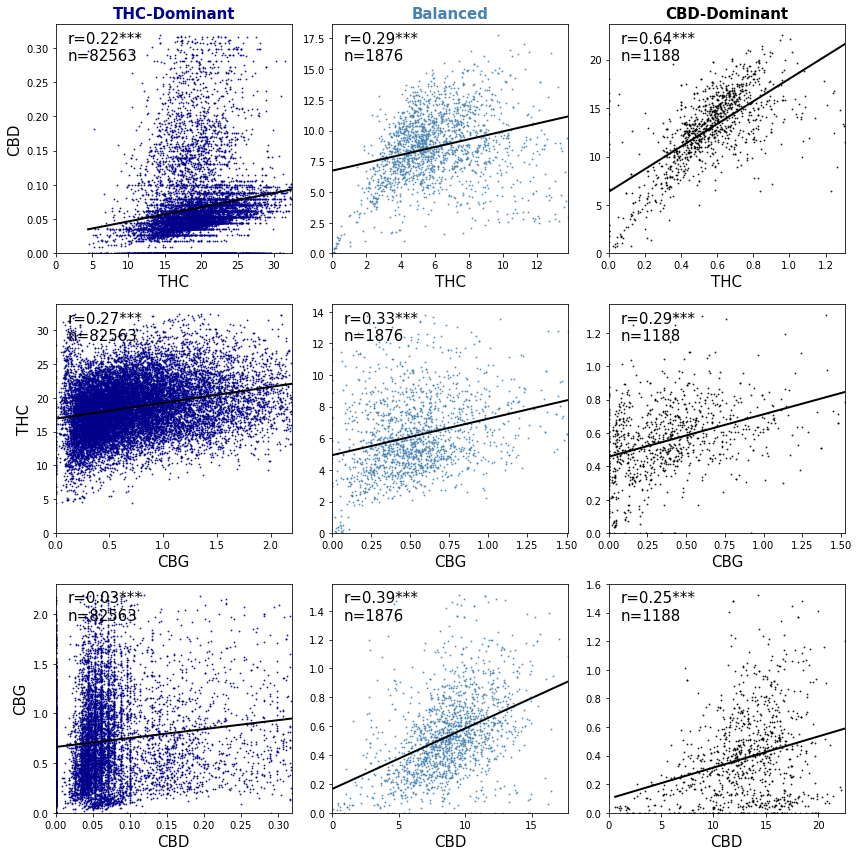

In [10]:
fig2_dict_list = [
            {'ct': 'THC-Dom', 'col_idx':0, 'color':'darkblue'},
            {'ct': 'Bal THC/CBD', 'col_idx': 1, 'color':'steelblue'},
            {'ct': 'CBD-Dom', 'col_idx': 2, 'color':'black'},
            ]

f,axs = plt.subplots(3,3,figsize=(12,12))


_lowess = False
_robust = False
_ci = 0 
_size = 3

df = lab_df.copy()
# df[common_cannabs] = df[common_cannabs].fillna(0)

for fig2_dict in fig2_dict_list:
    _df = df.loc[df['chemotype']==fig2_dict['ct']]
    
    x_ol = MAD_outlier(_df['tot_thc'], thresh=3.5)
    y_ol = MAD_outlier(_df['tot_cbd'], thresh=3.5)
    z_ol = MAD_outlier(_df['tot_cbg'], thresh=3.5)
    _df['ol_fig2'] = (x_ol+y_ol+z_ol)
    
    cannab_pair_list = [
        ('tot_thc','tot_cbd'),
        ('tot_cbg','tot_thc'),
        ('tot_cbd','tot_cbg')]
    for idx, (x, y) in enumerate(cannab_pair_list):
#         x_ol = MAD_outlier(_df[x], thresh=3.5)
#         y_ol = MAD_outlier(_df[y], thresh=3.5)
#         _df['ol_fig2'] = (x_ol+y_ol)
        
#         _df[[x,y]] = _df[[x,y]].fillna(0)
        
        if fig2_dict['ct']=='THC-Dom':
            df_samp = _df.loc[lab_df[lab_df['chemotype']=='THC-Dom'].sample(n=20000, random_state=57).index]
        else:
            df_samp = _df.sample(frac=1)
    
        fin_df = _df.loc[_df['ol_fig2']==False]
        sns.regplot(x=x, y=y,
                    data=df_samp.loc[df_samp['ol_fig2']==False],
                    marker='.', color=fig2_dict['color'],
                    scatter_kws={'s':_size}, line_kws={'color':'k','linewidth':2},lowess=_lowess,robust=_robust,ci=_ci,
                    ax=axs[idx, fig2_dict['col_idx']])
#         sns.scatterplot(x=x, y=y,
#                         data=df_samp.loc[df_samp['ol_fig2']==True],
#                         marker='.', color='red',
#                         ax=axs[idx, fig2_dict['col_idx']])
        axs[idx, fig2_dict['col_idx']].text(0.05,0.9,
                                            spearman_sig_string(fin_df[x], fin_df[y])+'\nn='+str(fin_df.shape[0]),
                                            ha='left',va='center',
                                            transform=axs[idx,fig2_dict['col_idx']].transAxes,fontsize=15)
        xlims = axs[idx, fig2_dict['col_idx']].get_xlim()
        ylims = axs[idx, fig2_dict['col_idx']].get_ylim()
        axs[idx, fig2_dict['col_idx']].set_xlim(0, xlims[1])
        axs[idx, fig2_dict['col_idx']].set_ylim(0, ylims[1])
    
    
# Label axes
axs[0,0].set_ylabel('CBD',fontsize=15)
axs[1,0].set_ylabel('THC',fontsize=15)
axs[2,0].set_ylabel('CBG',fontsize=15)

axs[2,0].set_xlabel('CBD',fontsize=15)
axs[2,1].set_xlabel('THC',fontsize=15)
axs[2,2].set_xlabel('CBG',fontsize=15)

for ax in axs[0,:]:
    ax.set_xlabel('THC',fontsize=15)
    
for ax in axs[1,:]:
    ax.set_xlabel('CBG',fontsize=15)
    
for ax in axs[2,:]:
    ax.set_xlabel('CBD',fontsize=15)
    
for ax in axs[:,1:].flatten():
    ax.set_ylabel(None)

axs[0,0].set_title('THC-Dominant',color='darkblue',fontsize=15,fontweight='bold')
axs[0,1].set_title('Balanced',color='steelblue',fontsize=15,fontweight='bold')
axs[0,2].set_title('CBD-Dominant',color='black',fontsize=15,fontweight='bold')

f.tight_layout()
# f.savefig('fig2_cannabinoid_correlation.png',dpi=300)
# f.savefig('cannabinoid_correlation.eps',dpi=300)
f.savefig('fig2_cannabinoid_correlation_2022_02_06.pdf',dpi=300)

## LLOQs/PCA

In [29]:
lab_df.head()

,u_id,lab_id,strain_slug,anon_producer,region,product_category,strain_category,strain_popularity,chemotype,has_cannabs,chemotype_ratio,tot_thc,tot_cbd,tot_cbg,tot_cbc,tot_cbn,tot_thcv,has_terps,total_terps,terp_var,top_terp_f,tot_ocimene,camphene,g_terpinene,tot_nerolidol_ct,humulene,caryophyllene,limonene,linalool,myrcene,bisabolol,b_pinene,a_terpinene,terpinolene,a_pinene,total_cannabs
0,0,canntest,NaN,1089,AK,FLOWER,None,NaN,THC-Dom,True,425.819531,20.103098,0.047210,1.097430,0.000000,0.0,0.255775,True,2.042793,0.020911,caryophyllene,0.251212,0.01,0.015323,0.010000,0.217018,0.560682,0.159195,0.032776,0.177072,0.029597,0.114252,0.010000,0.321310,0.075442,21.503513
1,1,canntest,NaN,1089,AK,FLOWER,None,NaN,THC-Dom,True,207.384250,17.775078,0.085711,0.904467,0.046734,0.0,0.050000,True,1.802569,0.015647,tot_ocimene,0.374661,0.01,0.015079,0.022216,0.143383,0.315326,0.127196,0.010000,0.199761,0.010000,0.069859,0.012731,0.365565,0.060920,18.861990
2,2,canntest,NaN,1089,AK,FLOWER,None,NaN,THC-Dom,True,230.122927,18.196924,0.079075,0.923358,0.056123,0.0,0.050000,True,1.657769,0.013292,terpinolene,0.334714,0.01,0.013090,0.026730,0.140367,0.306051,0.111072,0.022061,0.177568,0.010000,0.057884,0.011981,0.336826,0.049393,19.305480
3,3,canntest,NaN,1089,AK,FLOWER,None,NaN,THC-Dom,True,321.904704,19.302718,0.059964,0.517679,0.034465,0.0,0.050000,True,1.247020,0.013983,caryophyllene,0.010000,0.01,0.010000,0.000000,0.167629,0.385306,0.134872,0.056048,0.368547,0.048849,0.035711,0.000000,0.000000,0.020058,19.964826
4,4,canntest,NaN,1089,AK,FLOWER,None,NaN,THC-Dom,True,253.209507,18.224250,0.071973,0.966903,0.000000,0.0,0.231606,True,1.262112,0.006794,caryophyllene,0.158674,0.01,0.014013,0.010000,0.127600,0.317787,0.116072,0.029350,0.099418,0.010000,0.083642,0.010000,0.179980,0.056437,19.494732


### Cannabs

In [35]:
_df = lab_df.copy()
_df[common_cannabs] = lab_df[common_cannabs].fillna(0.1)

In [36]:
chemotypes = ['THC-Dom', 'Bal THC/CBD', 'CBD-Dom']
ct_palette = {'THC-Dom':'darkblue',
               'Bal THC/CBD': 'steelblue',
               'CBD-Dom': 'black'}
 
df_norm, arr, model = run_pca(_df, common_cannabs, norm=True, n_components=3, max_min_arr=False)

components = model.components_[[0,1,2],:]
comp_df = pd.DataFrame(components.T, columns=[0,1,2], index=common_cannabs)


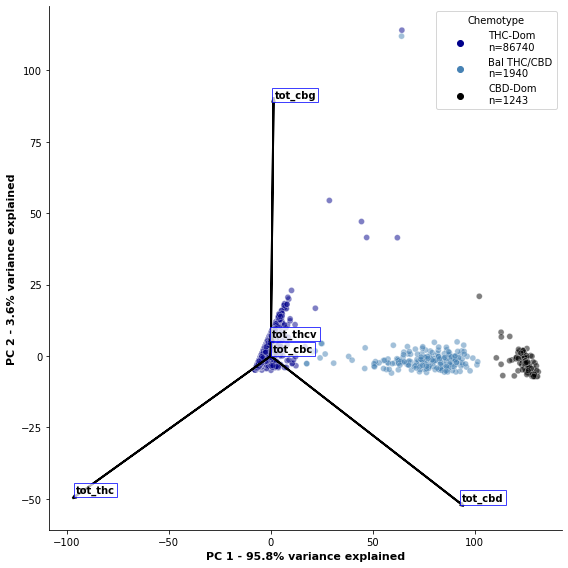

In [37]:
A = 0
B = 1

scatter_props = {'x': A, 'y': B,
                 'hue': 'chemotype', 'sort_list': chemotypes,
                 'palette': ct_palette,
                 'title': '', 'save_name': 'fig1/1d_scatter_pca_LLOQ',
                 'figsize':(8,8), 'sample_frac':10000,
                'comp_df': comp_df, 'n_display': 5}

pc1_var = model.explained_variance_ratio_[A]
pc2_var = model.explained_variance_ratio_[B]

scatter_props['x_label'] = 'PC '+str(A+1)+' - '+str(round(pc1_var*100,1))+'% variance explained'
scatter_props['y_label'] = 'PC '+str(B+1)+' - '+str(round(pc2_var*100,1))+'% variance explained'


run_graph(df_norm,
          **scatter_props)

In [41]:
95.8-96

-0.20000000000000284

### Terps

In [38]:
_df = terp_df.copy()
_df[common_terps] = terp_df[common_terps].fillna(0.01)

In [39]:
chemotypes = ['THC-Dom', 'Bal THC/CBD', 'CBD-Dom']
ct_palette = {'THC-Dom':'darkblue',
               'Bal THC/CBD': 'steelblue',
               'CBD-Dom': 'black'}
 
df_norm, arr, model = run_pca(_df, common_terps, norm=True, n_components=3, max_min_arr=False)

components = model.components_[[0,1,2],:]
comp_df = pd.DataFrame(components.T, columns=[0,1,2], index=common_terps)


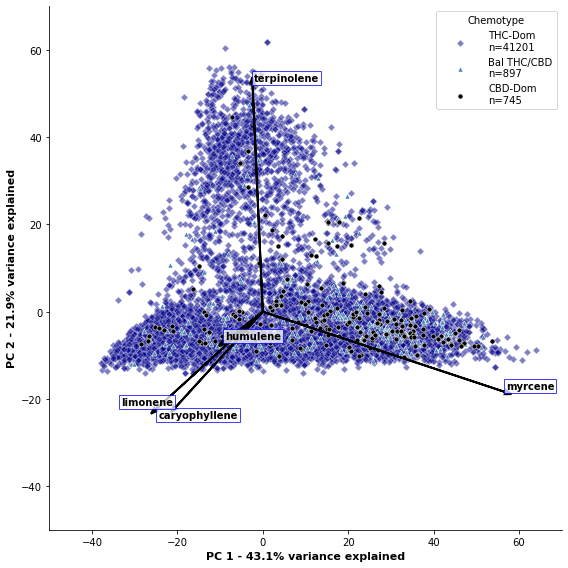

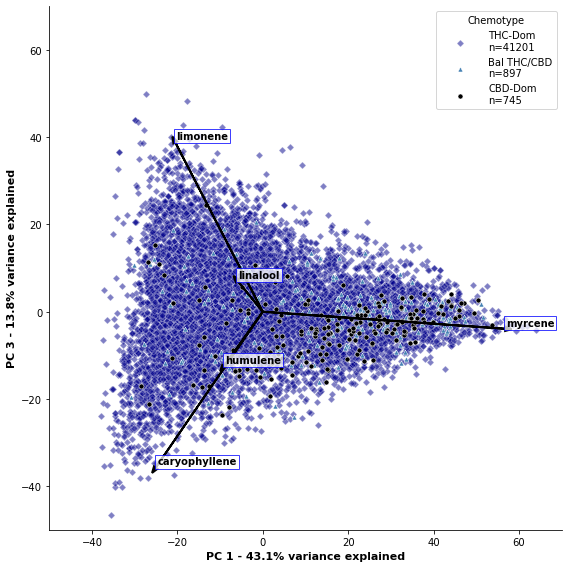

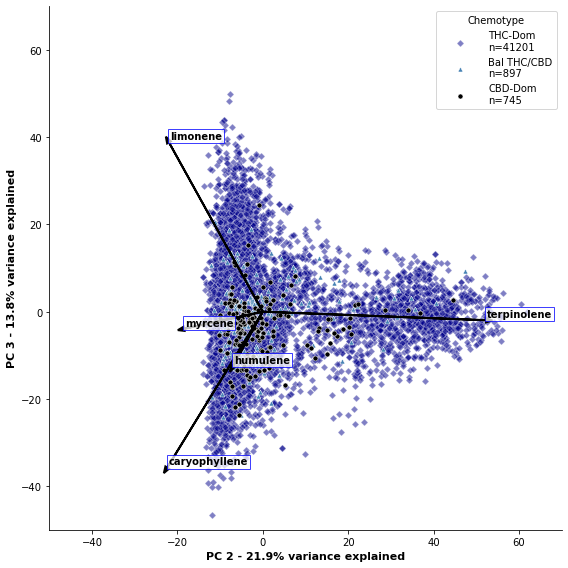

In [40]:
for comps, idx in zip([[0,1], [0,2], [1,2]], ['b','c','d']):
    A = comps[0]
    B = comps[1]

    scatter_props = {'x': A, 'y': B,
                     'xlims':(-50,70), 'ylims':(-50,70),
                     'hue': 'chemotype', 'sort_list': chemotypes,
                     'palette': ct_palette,
                     'title': '',
                     'figsize':(8,8), 'sample_frac':10000,
                    'comp_df': comp_df, 'n_display': 5}

    pc1_var = model.explained_variance_ratio_[A]
    pc2_var = model.explained_variance_ratio_[B]
    
    scatter_props['x_label'] = 'PC '+str(A+1)+' - '+str(round(pc1_var*100,1))+'% variance explained'
    scatter_props['y_label'] = 'PC '+str(B+1)+' - '+str(round(pc2_var*100,1))+'% variance explained'
    
    base_name = 'fig5/5{}_scatter_pca_LLOQ'.format(idx)
    scatter_props['save_name'] = base_name+'-'.join([str(x+1) for x in comps])

    run_graph(df_norm,
              **scatter_props)

## Figure 5e

In [127]:
strain_bool = pd.isna(terp_df['strain_slug'])
producer_bool = pd.isna(terp_df['anon_producer'])
fin_bool = strain_bool|producer_bool

# prod_df = terp_df[~pd.isna(terp_df['strain_slug'])].groupby(['strain_slug','anon_producer'])[common_terps+['tot_thc','tot_cbd']].mean()
prod_df = terp_df[~strain_bool].groupby(['strain_slug','anon_producer'])[common_terps+['tot_thc','tot_cbd']].mean()
prod_df = get_ct(prod_df)

In [121]:
def get_cos_dis(df):
    dis_scores = cosine_distances(df.fillna(0))
    dis_scores[dis_scores < 0.0000000000001] = np.nan
    return dis_scores

In [128]:
ct_sim_df = (prod_df.groupby('chemotype')[common_terps].apply(lambda x: list(np.nanmean(get_cos_dis(x[common_terps]), axis=0)))
                                     .explode()
                                     .astype('float64')
                                     .reset_index(drop=False)
                                     .rename(columns={0:'value'}))

In [123]:
def balance_groups(df, x='chemotype'):
    n = df.groupby(x).size().min()
    _df = pd.concat([df.loc[df['chemotype']==group].sample(n=n) for group in df[x].unique()])
    return _df
        

In [139]:
pval_dict = {pair:[] for pair in box_pairs}

In [135]:
group_dict

{('THC-Dom', 'Bal THC/CBD'): [],
 ('THC-Dom', 'CBD-Dom'): [],
 ('Bal THC/CBD', 'CBD-Dom'): []}

In [144]:
t_dict = {x:[] for x in box_pairs}

In [147]:
t_dict[pair].append(5)

In [148]:
t_dict

{('THC-Dom', 'Bal THC/CBD'): [],
 ('THC-Dom', 'CBD-Dom'): [],
 ('Bal THC/CBD', 'CBD-Dom'): [0, 3, 5]}

In [150]:
results[0]

0.05541568315788717

In [168]:
n = 245 # number of CBD-dom products, the smallest group size
box_pairs = list(itertools.combinations(chemotypes,r=2))
pval_dict = {pair:[] for pair in box_pairs}
dprime_dict = {pair:[] for pair in box_pairs}

runs = 500
bootstrap_df = pd.DataFrame(index=range(0, runs*3),
                            columns=['pair', 'p_val', 'd_prime'])
for run in range(0, runs):
    bal_df = balance_groups(ct_sim_df)
    
    for pair in box_pairs:
        results = get_stats(bal_df, pair, 'chemotype', return_vals=True)        
        pval_dict[pair].append(results[0])
        dprime_dict[pair].append(results[1])
        
pval_df = pd.DataFrame.from_dict(pval_dict, orient='index')
dprime_df = pd.DataFrame.from_dict(dprime_dict, orient='index')

In [169]:
pval_df.mean(axis=1)

(THC-Dom, Bal THC/CBD)    4.290830e-11
(THC-Dom, CBD-Dom)        9.933313e-19
(Bal THC/CBD, CBD-Dom)    5.901034e-02
dtype: float64

In [170]:
dprime_df.mean(axis=1)

(THC-Dom, Bal THC/CBD)    0.740864
(THC-Dom, CBD-Dom)        0.889811
(Bal THC/CBD, CBD-Dom)    0.182590
dtype: float64

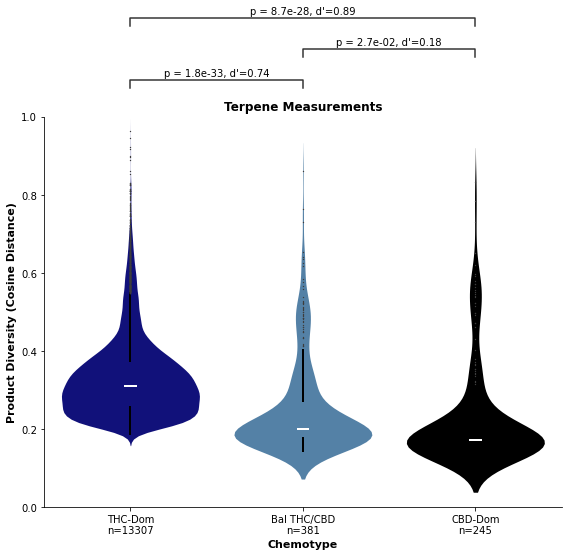

In [129]:
chemotypes = ['THC-Dom', 'Bal THC/CBD', 'CBD-Dom']
ct_palette = {'THC-Dom':'darkblue',
               'Bal THC/CBD': 'steelblue',
               'CBD-Dom': 'black'}

violin_props = {'x': 'chemotype', 'y': 'value',
                'ylims':(0,1),
                'order': chemotypes,
                'palette': ct_palette,
             'title': 'Terpene Measurements', 'save_name': 'fig5/5e_violin_terp_sim_prod',
             'x_label': 'Chemotype', 'y_label': 'Product Diversity (Cosine Distance)',
             'avg': False, 'sig_comp': True,
             'figsize':(8,8), 'sample_frac':1}

run_graph(ct_sim_df,
          **violin_props)

# Misc

In [11]:
thc_terp_df = terp_df.loc[thc_bool].copy()
df_norm, arr, model = run_pca(thc_terp_df, common_terps, norm=True, n_components=3)

# set up kmeans
clust = KMeans(3, random_state=56)

# get cluster labels
df_norm['kmeans_label'] = clust.fit_predict(df_norm[common_terps])
clust_dict = {x:y for x,y in zip(df_norm['kmeans_label'].value_counts().index, ['A','B','C','D'])}
df_norm['kmeans_label'] = df_norm['kmeans_label'].replace(clust_dict)

In [17]:
df_norm['top_terp_f'].value_counts()/df_norm.shape[0]*100

myrcene             38.033057
caryophyllene       25.567341
limonene            18.596636
terpinolene         10.007039
a_pinene             2.817893
other                2.228101
tot_ocimene          0.968423
linalool             0.677168
a_terpinene          0.567947
tot_nerolidol_ct     0.245140
humulene             0.148055
bisabolol            0.065532
b_pinene             0.033980
camphene             0.021844
g_terpinene          0.021844
Name: top_terp_f, dtype: float64

In [19]:
def per_counts(x):
    return x.value_counts()/x.shape[0]*100

df_norm.groupby('top_terp_f')['kmeans_label'].apply(lambda x: per_counts(x))

top_terp_f         
a_pinene          B     61.154177
                  A     33.074935
                  C      5.770887
a_terpinene       C    100.000000
b_pinene          A     57.142857
                  C     42.857143
bisabolol         A    100.000000
camphene          B     77.777778
                  A     22.222222
caryophyllene     A     97.693184
                  C      1.746725
                  B      0.560091
g_terpinene       C     88.888889
                  A     11.111111
humulene          A     98.360656
                  C      1.639344
limonene          A     99.712869
                  B      0.247977
                  C      0.039154
linalool          A     98.207885
                  B      1.433692
                  C      0.358423
myrcene           B     84.058711
                  A     13.688577
                  C      2.252712
other             A     70.370370
                  B     18.191721
                  C     11.437908
terpinolene       C     99.9